<a href="https://colab.research.google.com/github/pazju/Titanic-Dataset-/blob/main/Titanic_JCPaz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Taller Semana 11, TITANIC**
**Juan Camilo Paz Silva**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition # Modulo que incluye PCA y Kernel PCA 
from sklearn import datasets
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles, make_moons, make_classification
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,roc_auc_score

from sklearn import svm


In [ ]:
#DATOS ENTRENAMIENTO Y TEST
data_train=pd.read_csv("train.csv")
data_test=pd.read_csv("test.csv")

test_ids = data_test["PassengerId"]



In [ ]:
#DATOS ANTES DE LA LIMPIEZA
data_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
#LIMPIEZA DE DATOS
def clean(data):
  data = data.drop(["Ticket","Cabin","Name","PassengerId"], axis=1)
  cols = ["Age","SibSp","Parch","Fare"]
  for col in cols:
    data[col].fillna(data[col].median(), inplace=True) #Los espacios sin datos se llenan con la mediana de los otros valores de la columna
  data.Embarked.fillna("Unknown", inplace=True) #Los valores del lugar de embarcación se llenan con un token "Unknown"
  return data

data_train=clean(data_train)
data_test=clean(data_test)

In [ ]:
#DATOS LIMPIOS
data_train.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


In [ ]:
#CONVERTIR STRINGS A NÚMEROS
from numpy.lib.shape_base import column_stack
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

cols=["Sex","Embarked"]

for col in cols:
  data_train[col]=label_encoder.fit_transform(data_train[col])
  data_test[col]=label_encoder.transform(data_test[col])  
  print(label_encoder.classes_)

data_train.head(5)

# 1 = male
# 0 = female

['female' 'male']
['C' 'Q' 'S' 'Unknown']


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [ ]:
#SEPARACIÓN CONJUNTO ENTRENAMIENTO Y VALIDACIÓN

y = data_train['Survived'].values
X = data_train[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.3)

print(X_train.shape)
print(X_test.shape)


(623, 7)
(268, 7)


In [ ]:
#ESCALIZACIÓN DE LOS DATOS
# Calcula la media y la desviación estandar del conjunto entrenado para escalizar todos los datos
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


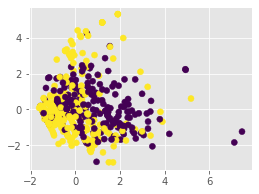

Pesos de PCA: [0.25935439 0.24121199 0.14723623 0.12065836 0.09828936 0.08128189
 0.05196778]


In [ ]:
#Preparar figura 2D
fig = plt.figure(2, figsize=(4, 3))
n=7

pca = decomposition.PCA(n_components=n)

pca.fit(X_train)
X_train = pca.transform(X_train)

# Reorder the labels to have colors matching the cluster results

y_train = np.choose(y_train, [1,0]).astype(np.float)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,)

plt.show()
print("Pesos de PCA:",pca.explained_variance_ratio_)

In [ ]:
#Thumbrule conservar el 97%
print("Varianza explicada total de una reducción a N componentes principales: ", sum(pca.explained_variance_ratio_))

Varianza explicada total de una reducción a N componentes principales:  0.9999999999999998


**REGRESIÓN LOGISTICA**

0.013000000000000001


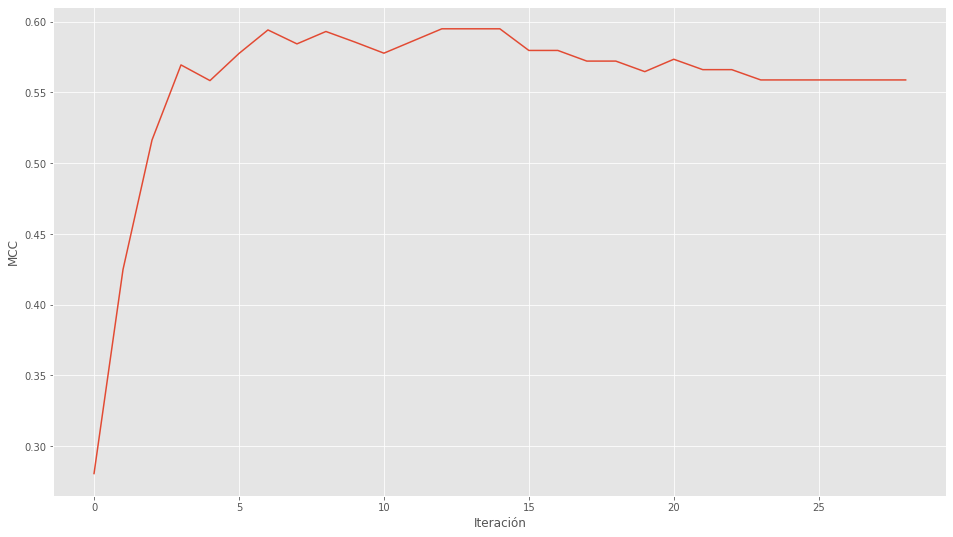

In [ ]:
# OPTIMIZACIÓN HIPERPARAMETROS

c_range = np.arange(0.001,0.03,0.001)
scores = []
hiperparametro_LR = []
for c in c_range:
    LR = LogisticRegression(C = c,penalty='l2', max_iter=1000,  random_state=0)
    # C -> Regularización
    LR.fit(X_train, y_train)
    scores.append(matthews_corrcoef(y_test, LR.predict(X_test)))
    hiperparametro_LR.append((c))
plt.figure()
plt.xlabel('Iteración')
plt.ylabel('MCC')
plt.plot(scores)
indice=np.argmax(scores)
print(hiperparametro_LR[indice])

In [ ]:
LR = LogisticRegression(penalty='l2', max_iter=1000, C=0.013, random_state=0) # C ; penalty='l2',
LR.fit(X_train, y_train)
y_test_predicted = LR.predict(X_test)
y_test_scores = LR.predict_proba(X_test)
MCC = matthews_corrcoef(y_test, y_test_predicted)
print("matthews_corrcoef", MCC)
ACC = accuracy_score(y_test, y_test_predicted)
print("Accuracy", ACC)

matthews_corrcoef 0.5949273310408827
Accuracy 0.8134328358208955


El c escogido sirve para obtener el mejor resultado

**KNN**

(13, 'uniform', 'euclidean')


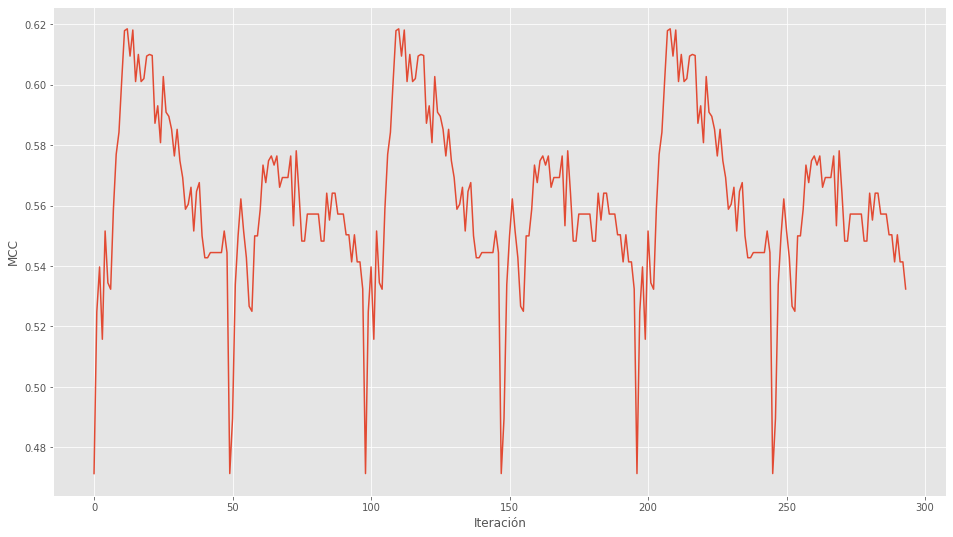

In [ ]:
# OPTIMIZACIÓN HIPERPARAMETROS

k_range = range(1, 50)
distance_prueba = ["euclidean","manhattan","chebyshev"]
weight_prueba = ["uniform","distance"]
scores = []
hiperparametros=[]


for dist in distance_prueba:
  for w in weight_prueba:
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors = k,weights=w,metric=distance, metric_params=None,algorithm='brute')
        #knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train, y_train)
        scores.append(matthews_corrcoef(y_test, knn.predict(X_test)))
        hiperparametros.append((k,w,dist))
plt.figure()
plt.xlabel('Iteración')
plt.ylabel('MCC')
plt.plot(scores)
indice=np.argmax(scores)
print(hiperparametros[indice])

In [ ]:
KNN = KNeighborsClassifier(n_neighbors = 13,weights='uniform',metric='euclidean', metric_params=None,algorithm='brute')

KNN.fit(X_train, y_train)
y_test_predicted = KNN.predict(X_test)
y_test_scores = KNN.predict_proba(X_test)
MCC = matthews_corrcoef(y_test, y_test_predicted)
print("matthews_corrcoef", MCC)
ACC = accuracy_score(y_test, y_test_predicted)
print("Accuracy", ACC)

matthews_corrcoef 0.618506725078256
Accuracy 0.8246268656716418


**SVM**

(0.002, 'linear')


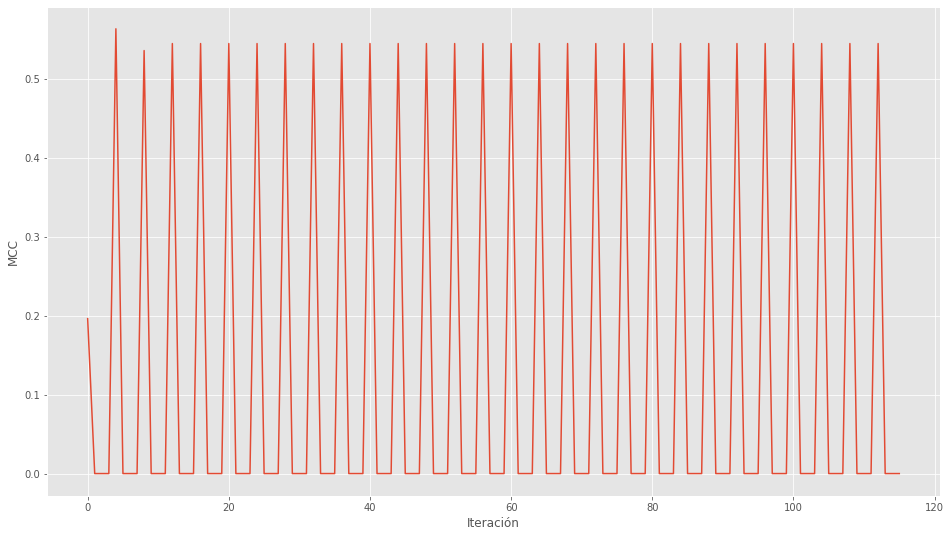

In [ ]:
# OPTIMIZACIÓN HIPERPARAMETROS
c_svm = np.arange(0.001,0.03,0.001)
kernels = ["linear","poly","rbf","sigmoid"]
scores = []
hiperparametros_SVM = []
for c in c_svm:
  for ker in kernels:
      SVM = svm.SVC(C=c, kernel=ker,gamma=0.01)
      SVM.fit(X_train, y_train)
      scores.append(matthews_corrcoef(y_test, SVM.predict(X_test)))
      hiperparametros_SVM.append((c,ker))
plt.figure()
plt.xlabel('Iteración')
plt.ylabel('MCC')
plt.plot(scores)
indice_svm=np.argmax(scores)
print(hiperparametros_SVM[indice_svm])

In [ ]:
SVM = svm.SVC(C=0.002, kernel='linear',gamma=0.01)
SVM.fit(X_train, y_train)
y_test_predicted = SVM.predict(X_test)
y_test_scores = SVM.decision_function(X_test)
MCC = matthews_corrcoef(y_test, y_test_predicted)
print("matthews_corrcoef", MCC)
ACC = accuracy_score(y_test, y_test_predicted)
print("Accuracy", ACC)

matthews_corrcoef 0.5631269848359428
Accuracy 0.7985074626865671


**Se selecciona KNN debido a su resultado de 
MCC = 0.618506725078256** 

In [ ]:
# RE-ENTRENAMIENTO

scaler = StandardScaler()
scaler.fit(X)
x_retrain = scaler.transform(X)
scaler.fit(data_test)
data_test = scaler.transform(data_test)

KNN = KNeighborsClassifier(n_neighbors = 13,weights='uniform',metric='euclidean', metric_params=None,algorithm='brute')

KNN.fit(x_retrain, y)
y_test_predicted = KNN.predict(X_test)
y_test_scores = KNN.predict_proba(X_test)
MCC = matthews_corrcoef(y_test, y_test_predicted)
print("matthews_corrcoef", MCC)
ACC = accuracy_score(y_test, y_test_predicted)
print("Accuracy", ACC)


matthews_corrcoef 0.6679380776590629
Accuracy 0.8470149253731343


In [ ]:
# data_test
# test_ids

predictions = KNN.predict(data_test)

df = pd.DataFrame({"PassengerId":test_ids.values,
                   "Survived": predictions,
                   })
df.to_csv("submission.csv", index=False)

Conclusiones:

- El conjunto de datos no necesita una reducción dimensional, como se puede observar en el resultado de la varianza explicada total de una reducción a 7 componentes principales, este es del 99.99% y además los pesos de PCA de cada uno de estos componentes contiene una cantidad de información que no se puede quitar. Por ejemplo, el séptimo elemento contiene aproximadamente un 5% de la información. 

- El hacer reducción dimensional y PCA, facilita el trabajo del clasificador, porque evita el usar un vector de BIAS. En este caso no se podía hacer reducción dimensional. 

- La regularización aumenta la estabilidad númerica

- Se optimizan los hiperparametros para obtener el método con mejor MCC.

- El accuracy tiende a resultados que no son realistas si el dataset se encuentra desbalanceado, por esto se usa MCC.



### **RESULTADO KAGGLE**